## Trabajo Practico 5

#### Materia: Vision por Computadora 1
#### Alumno: Lucas Rivela

In [102]:
import cv2 as cv
import imutils
import math
import matplotlib.pyplot as plt
import numpy as np
import random
import time

#### Parte 1 - Pruebo el método para un frame

In [3]:
# Abrimos el archivo
filename = 'slow_traffic_small.mp4'
capture = cv.VideoCapture(filename)

In [4]:
# Leo primer frame
ret, frame = capture.read()

In [5]:
# Convierto frame a RGB y miro dimensiones
frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
frame.shape

(360, 640, 3)

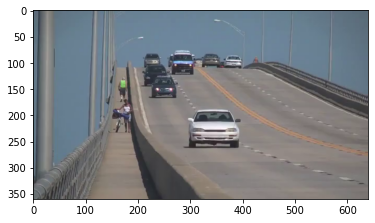

In [6]:
plt.imshow(frame)

In [7]:
# Me fijo cuantos frames tiene el video
length = int(capture.get(cv.CAP_PROP_FRAME_COUNT))
length

914

In [65]:
# Genero numeros aleatorios para luego leer los frames
FRAMES_NUM = 30
capture.set(cv.CAP_PROP_POS_FRAMES, 0)
sampl = np.random.randint(low=1, high=914, size=(FRAMES_NUM,))
sampl.shape

(30,)

In [66]:
# Cargo los frames a memoria
lista_frames = []
for s in sampl:
    capture.set(1, s)
    ret, frame = capture.read()
    frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    lista_frames.append(frame)

In [67]:
# Genero un tensor con los 30 frames
# Las dimensiones correspoden a frames x alto x ancho x canal
tensor = np.array(lista_frames)
tensor.shape

(30, 360, 640, 3)

In [68]:
# Genero un frame que representa la mediana de esos 30 frames
media = np.median(tensor, axis=0)
media.shape

(360, 640, 3)

In [69]:
# Normalizo entre 0 y 255
media = cv.normalize(media, media, 0, 255, cv.NORM_MINMAX).astype('uint8')

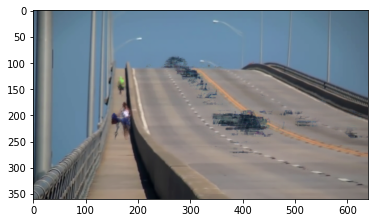

In [70]:
plt.imshow(media)

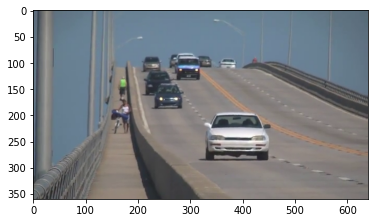

In [71]:
# Leo un frame y lo muestro
capture.set(1, 50)
ret, frame_actual = capture.read()
frame_actual = cv.cvtColor(frame_actual, cv.COLOR_BGR2RGB)
plt.imshow(frame_actual)

In [72]:
# Aplico GaussianBlur a la imagen de la mediana y al frame actual
media = cv.GaussianBlur(media, (3, 3), 0)
frame_actual = cv.GaussianBlur(frame_actual, (3, 3), 0)

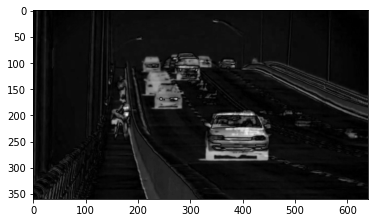

In [73]:
# Convierto ambas imagenes a escala de grises
grayMedianFrame = cv.cvtColor(media, cv.COLOR_BGR2GRAY)
grayFrameActual = cv.cvtColor(frame_actual, cv.COLOR_BGR2GRAY)

# Hago la resta entre las imagenes
dframe = cv.absdiff(grayFrameActual, grayMedianFrame)
plt.imshow(dframe, cmap='gray')

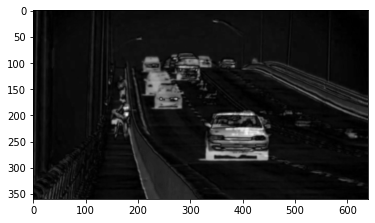

In [74]:
# Aplico GaussianBlur a la resta
dframe = cv.GaussianBlur(dframe, (3, 3), 0)
#dframe = cv.medianBlur(dframe, 11, dframe)
plt.imshow(dframe, cmap='gray')

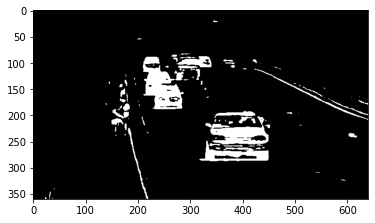

In [75]:
# Binarizo utilizando Otsu
th, dframe = cv.threshold(dframe, 30, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)
plt.imshow(dframe, cmap='gray')

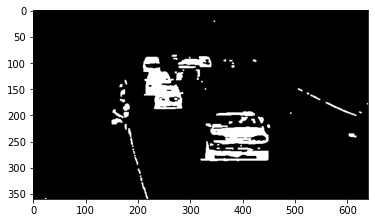

In [77]:
# Creamos un elemento estructurante y aplicamos operaciones morfologicas
kernel1 = np.ones((3,3),np.uint8)
opening = cv.morphologyEx(dframe, cv.MORPH_OPEN, kernel1, iterations = 1)
plt.imshow(opening, cmap='gray')

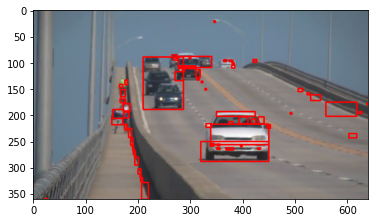

In [78]:
cnts, _ = cv.findContours(opening.copy(), cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
for cnt in cnts:
    x,y,w,h = cv.boundingRect(cnt)
    frame_actual = cv.rectangle(frame_actual,(x,y),(x+w,y+h),(255,0,0),2)

plt.imshow(frame_actual)

#### Parte 2 - Extrapolo a video

In [107]:
# Abrimos el archivo
FILENAME = 'slow_traffic_small.mp4'

In [112]:
def naive_background_substraction(filename, n_frames=25, refresh_interval=3):
    """
    Funcion que toma el nombre de un archivo, la cantidad de frames a samplear y el intervalo de refresco y genera una mascara binarizada que detecta los objetos en foreground. 
    Los frames y el intervalo de refresco se utilizan para calcular la mediana para el background y cada cuanto se tiene que recalcular.
    Argumentos
    filename: Imagen de entrada en escala de grises
    n_frames: Cantidad de frames a utilizar para el calculo de la mediana
    refresh_interval: Intervalo en segundos que se espera para recalcular el background
    ---------------------------------------
    Retorno
    Ninguno. Genera un video en el directorio donde se está ejecutando.
    """
    start = time.time()

    capture = cv.VideoCapture(filename)  # Cargo el video con OpenCV

    frame_width = int(capture.get(3))  # Tomo el ancho del video (en pixeles)
    frame_height = int(capture.get(4))  # Tomo el alto del video (en pixeles)
    size = (frame_width, frame_height)
    fps = math.ceil(capture.get(cv.CAP_PROP_FPS))  # Tomo los frames por segundo del video

    result = cv.VideoWriter('resultadoTP5.avi', cv.VideoWriter_fourcc(*'DIVX'), capture.get(cv.CAP_PROP_FPS), size, 0)  # Genero un video writer donde guardar el resultado
    
    
    every_n_frames = refresh_interval * fps  # Calculo cada cuantos frames tengo que recalcular el background

    frameIds = capture.get(cv.CAP_PROP_FRAME_COUNT) * np.random.uniform(size=n_frames)  # Tomo un set inicial de frames para calcular el background con la mediana

    # Cargo los frames en una lista
    frames = []
    for fid in frameIds:
        capture.set(cv.CAP_PROP_POS_FRAMES, fid)
        ret, frame = capture.read()
        frames.append(frame)

    # Calculo la mediana
    medianFrame = np.median(np.array(frames), axis=0).astype(dtype=np.uint8)
    # Normalizo entre 0 y 255
    medianFrame = cv.normalize(medianFrame, medianFrame, 0, 255, cv.NORM_MINMAX).astype('uint8')
    # Aplico suavizado gaussiano
    medianFrame = cv.GaussianBlur(medianFrame, (3, 3), 0)

    # Reseto el numero de frame al inicial
    capture.set(cv.CAP_PROP_POS_FRAMES, 0)

    # Convierto el background (la imagen de mediana) a escala de grises
    grayMedianFrame = cv.cvtColor(medianFrame, cv.COLOR_BGR2GRAY)

    # Recorro el video
    ret = True
    frame_counter = 0  # Esta variable va contando cuantos frames lei
    past_frames = []  # En esta variable me guardo los frames que lei
    while(ret):
        # Read frame
        ret, frame_rgb = capture.read()
        
        if not ret:
            break
        
        past_frames.append(frame_rgb)
        frame_rgb = cv.GaussianBlur(frame_rgb, (3, 3), 0)  # Aplico suavizado gaussiano en el frame

        # Si es momento de actualizar el background
        if frame_counter == every_n_frames:
            medianFrame = np.median(np.array(random.choices(past_frames, k=n_frames)), axis=0).astype(dtype=np.uint8)  # Calculo la mediana
            medianFrame = cv.normalize(medianFrame, medianFrame, 0, 255, cv.NORM_MINMAX).astype('uint8')  # Normalizo entre 0 y 255
            medianFrame = cv.GaussianBlur(medianFrame, (3, 3), 0)  # Aplico suavizado gaussiano
            grayMedianFrame = cv.cvtColor(medianFrame, cv.COLOR_BGR2GRAY)  # Convierto a escala de grises
            frame_counter = 0  # Reseteo contador a 0
        else:
            frame_counter += 1

        frame_rgb = cv.GaussianBlur(frame_rgb, (3, 3), 0)  # Aplico suavizado gaussiano
        frame = cv.cvtColor(frame_rgb, cv.COLOR_BGR2GRAY)  # Convierto a escala de grises
        
        dframe = cv.absdiff(frame, grayMedianFrame)  # Hago la resta entre las imagenes
        dframe = cv.GaussianBlur(dframe, (3, 3), 0)  # Aplico suavizado gaussiano

        th, dframe = cv.threshold(dframe, 30, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)  # Binarizo utilizando Otsu

        # Creamos un elemento estructurante y aplicamos operaciones morfologicas
        kernel = np.ones((3,3),np.uint8)
        opening = cv.morphologyEx(dframe, cv.MORPH_OPEN, kernel, iterations = 1)

        #cnts, _ = cv.findContours(opening, cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)

        #for cnt in cnts:
        #    x,y,w,h = cv.boundingRect(cnt)
        #    frame_rgb = cv.rectangle(frame_rgb,(x,y),(x+w,y+h),(255,0,0),2)
        
        #cv.imshow('frame', frame_rgb)
        #cv.waitKey(20)

        result.write(opening.astype('uint8'))  # Guardo la imagen resultante


    # Release
    capture.release()
    result.release()

    cv.destroyAllWindows()
    
    elapsed = time.time() - start
    print('Transcurrieron {} segundos'.format(elapsed))



In [113]:
naive_background_substraction(FILENAME)

Transcurrieron 6.125291109085083 segundos


Nota: el video generado es el archivo resultadoTP5.avi

#### Parte 3 - Comparación con MOG2

In [105]:
def mog2_background_substraction(filename):
    """
    Funcion que toma el nombre de un archivo y genera una mascara binarizada que detecta los objetos en foreground. 
    Argumentos
    filename: Imagen de entrada en escala de grises
    ---------------------------------------
    Retorno
    Ninguno. Genera un video en el directorio donde se está ejecutando.
    """
    
    start = time.time()

    capture = cv.VideoCapture(filename)

    frame_width = int(capture.get(3))
    frame_height = int(capture.get(4))
    size = (frame_width, frame_height)
    fps = math.ceil(capture.get(cv.CAP_PROP_FPS))

    result = cv.VideoWriter('MOG2-TP5.avi', cv.VideoWriter_fourcc(*'DIVX'), capture.get(cv.CAP_PROP_FPS), size, 0)

    backSub = cv.createBackgroundSubtractorMOG2()
    # Corremos la sustraccion
    while True:
        # Leemos un frame
        ret, frame = capture.read()
        if frame is None:
            break
        
        # Aplicamos la sustracción al frame leído
        # Cada frame se utiliza tanto para calcular la máscara de primer plano como para actualizar el fondo.
        fgMask = backSub.apply(frame)

        # Escribimos sobre la imagen el número de frame procesado
        cv.rectangle(frame, (10, 2), (100,20), (255,255,255), -1)
        cv.putText(frame, str(capture.get(cv.CAP_PROP_POS_FRAMES)), (15, 15), cv.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0))


        result.write(fgMask.astype('uint8'))

    capture.release()
    cv.destroyAllWindows()
    

    elapsed = time.time() - start
    print('Transcurrieron {} segundos'.format(elapsed))

In [106]:
mog2_background_substraction(FILENAME)

Transcurrieron 4.941254138946533 segundos


Nota: El video generado es el archivo MOG2-TP5.avi

#### Conclusiones



Se implementó el algoritmo Naive Background Substraction.

Implementar suavizado gaussiano en distintos puntos del algoritmo mejoró un poco los resultados. Utilizar procesamiento morfólogico al final terminó de sacar el ruido que quedaba en la máscara binaria.
También se probó utilizar distintos thresholds para la máscara binaria pero terminé eligiendo Otsu porque los resultados eran mejores.

#### Comparación con MOG2

A nivel performance, MOG2 resulta mejor, dando siempre tiempos de ejecución menores.

NBS es muy sensible a variaciones en las condiciones de iluminación, es por eso que se recomienda ir recalculando el background cada cierto periodo de tiempo. Por otro lado, el resultado de NBS depende mucho de cómo se calcula la mediana. Algunas implementaciones lo que hacen es ir recalculandolo frame a frame utilizando un promedio ponderado de los frames pasados.

Aplicar un poco de procesamiento morfólogico al resultado de MOG2 puede sacar fácilmente el ruido que se ve en el video.